In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import math

configuration = tflscripts.read_configuration()

In [51]:
datasets_and_devices = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134']
]

complete_df = []
for dataset, device in datasets_and_devices:
    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

    complete_df.append(df)

complete_df = pd.concat(complete_df)
complete_df = complete_df.reset_index()

In [69]:
def read_complete_dataset(dataset,
                          device,
                          sensor_streams,
                          activities,
                          complete_df,
                          clip_to=2,
                          anomaly_percentile=100):

    dataset_folder = '../datasets/'

    dataset_path = dataset_folder + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    df = df.filter(regex=sensor_streams + '|label')

    value_columns = df.filter(regex=sensor_streams).columns
    mean = complete_df[value_columns].mean()
    std = complete_df[value_columns].std()

    if clip_to is not None:
        df[value_columns] = df[value_columns].clip(mean - clip_to * std, mean + clip_to * std, axis=1)

    df[value_columns] = (df[value_columns] - mean) / std
    df = df.replace([np.inf, -np.inf, np.nan], 0)
    df = tflscripts.add_fft_features_for(df, 'MICROPHONE_fft')
    df = tflscripts.add_fft_features_for(df, 'ACCEL_fft')

    if anomaly_percentile < 100:
        anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
        df['anomalies'] = anomalies

    df[value_columns] = StandardScaler().fit_transform(df[value_columns])

    activities_i = [configuration['activities'].index(a) for a in activities]
    df = df.loc[df.label.isin(activities_i)]

    if anomaly_percentile < 100:
        anomaly_threshold = np.percentile(df.anomalies.values, 100 - anomaly_percentile)
        print(anomaly_threshold)
        df = df.loc[df.anomalies > anomaly_threshold]

    return df[value_columns].values, df.label.values, df[value_columns].columns

In [70]:
sensor_streams = 'MICROPHONE_fft|ACCEL_fft'
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
#     "Null",
#         "Faucet",
    "Kettle",
#         "Phone ringing",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
#         "Microwave door opened",
#         "Microwave door closed",
#         "Cupboard door opened",
#         "Cupboard door closed",
#         "Microwave button press",
#     "Taking ice",
#         "Making popcorn in microwave",
#         "Room lights off",
    "Knocking",
#         "Frequency sweep",
    "Phone vibrating"
]

anomaly_percentile = 50

source_device = '128.237.254.195'
source_dataset = 'synergy-final-iter1'
target_device = '128.237.248.186'
target_dataset = 'synergy-final-iter2'

x_train, y_train, _ = read_complete_dataset(device=source_device,
                                            dataset=source_dataset,
                                            activities=activities,
                                            sensor_streams=sensor_streams,
                                            complete_df=complete_df,
                                            anomaly_percentile=anomaly_percentile)
x_test, y_test, _ = read_complete_dataset(device=target_device,
                                          dataset=target_dataset,
                                          activities=activities,
                                          sensor_streams=sensor_streams,
                                          complete_df=complete_df,
                                          anomaly_percentile=anomaly_percentile)

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.SVC(kernel='linear',
                    decision_function_shape='ovr'))
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

5.77473871341
5.44812267279


0.58450009859988172

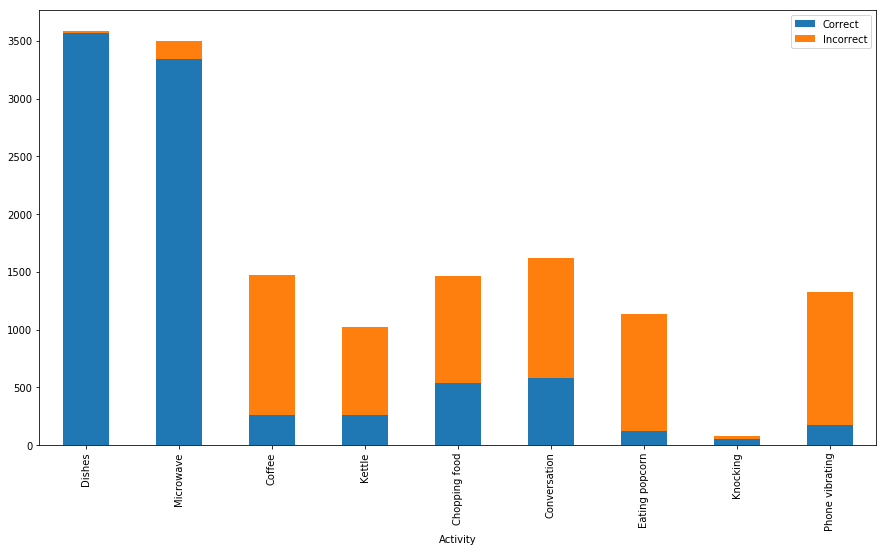

In [71]:
results = []
configuration = tflscripts.read_configuration()
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])
results = pd.DataFrame(results)
results.columns = ['Activity', 'Correct', 'Incorrect']
results = results.set_index('Activity')
results.plot.bar(stacked=True)

In [72]:
sensor_streams = 'MICROPHONE_fft|ACCEL_fft'
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

tests = [
    ['synergy-final-iter1', '128.237.254.195', 'synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134', 'synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134', 'scott-final-iter1', '128.237.248.186'],
#     ['robotics-final', '128.237.246.127', 'scott-final-iter1', '128.237.247.134'],
    ['robotics-final', '128.237.246.127', 'robotics-final', '128.237.247.134'],
]

test_labels = [
    'Synergy, sink, replica',
    'Scott (right) to Synergy (sink)',
    'Scott (right) to Scott (left)',
#     'Robotics (coffee) to Scott (right)',
    'Robotics (coffee) to Robotics (sink)',
]

percentiles = [5, 10, 30, 50, 100]

In [ ]:
results = []
accuracies = []


for n, test in enumerate(tests):
    source_dataset = test[0]
    source_device = test[1]
    target_dataset = test[2]
    target_device = test[3]

    for percentile in percentiles:
        x_train, y_train, _ = read_complete_dataset(device=source_device,
                                                 dataset=source_dataset,
                                                 activities=activities,
                                                 sensor_streams=sensor_streams,
                                                 complete_df=complete_df,
                                                 anomaly_percentile=percentile)
        x_test, y_test, _ = read_complete_dataset(device=target_device,
                                               dataset=target_dataset,
                                               activities=activities,
                                               complete_df=complete_df,
                                               sensor_streams=sensor_streams,
                                               anomaly_percentile=percentile)

        ppl = Pipeline([
            ('impute', Imputer()),
        #     ('clf', OneVsRestClassifier(RandomForestClassifier()))
            ('clf', svm.SVC(kernel='linear',
                            decision_function_shape='ovr'))
        #     ('clf', LogisticRegression())
        ])

        ppl.fit(x_train, y_train)

        predicted = ppl.predict(x_test)
        accuracy = accuracy_score(y_test, predicted)
        accuracies.append([n, percentile, accuracy])

        configuration = tflscripts.read_configuration()
        for i in np.unique(y_test):
            activity = configuration['activities'][int(i)]
            correct = len([x for x in predicted[y_test == i] if x == i])
            incorrect = len([x for x in predicted[y_test == i] if x != i])
            results.append([n, percentile, activity, correct, incorrect])

19.2881102754
14.8887879072
14.7981661654
11.6792167107
6.64845216485
5.86656221956
5.77473871341
5.44812267279
6.61399918185
14.8887879072
6.15901730379
11.6792167107
5.71771532009
5.86656221956
5.51391167453
5.44812267279


In [11]:
results_df = pd.DataFrame(results)
results_df.columns = ['test', 'anomaly_percentile', 'activity', 'correct', 'incorrect']
results_df['label'] = results_df.activity + ' ' + (results_df.anomaly_percentile / 100).astype(str)
results_df = results_df.sort_values('label')

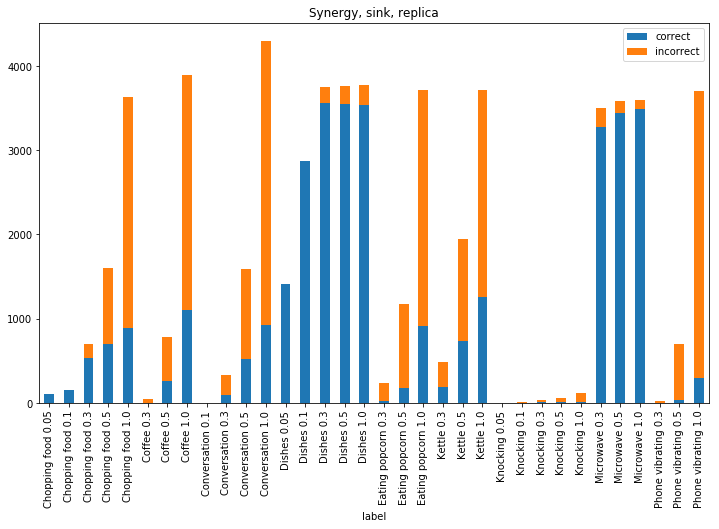

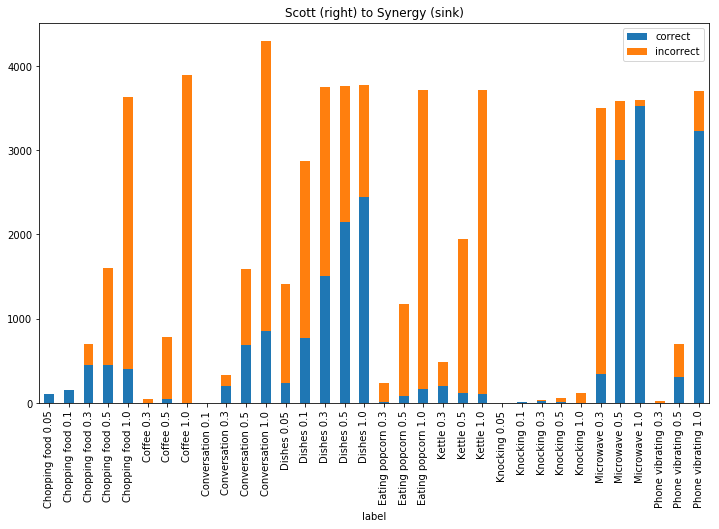

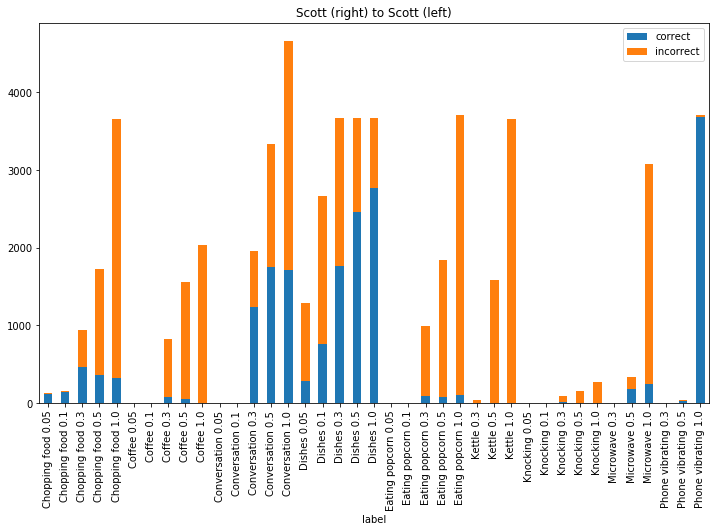

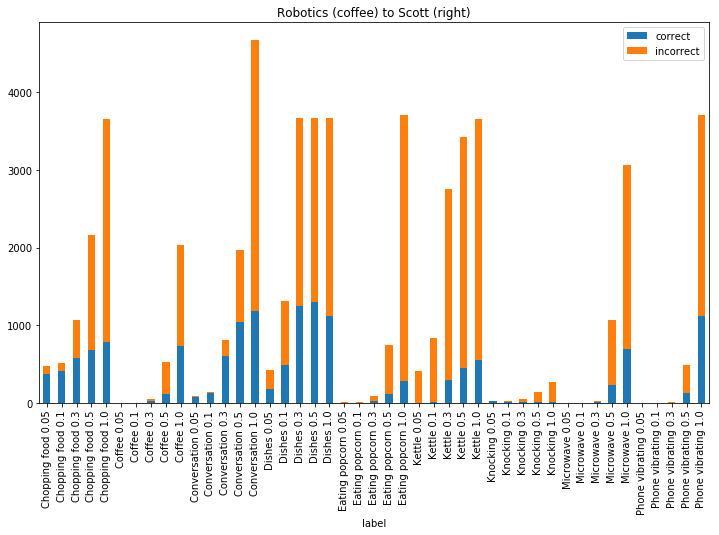

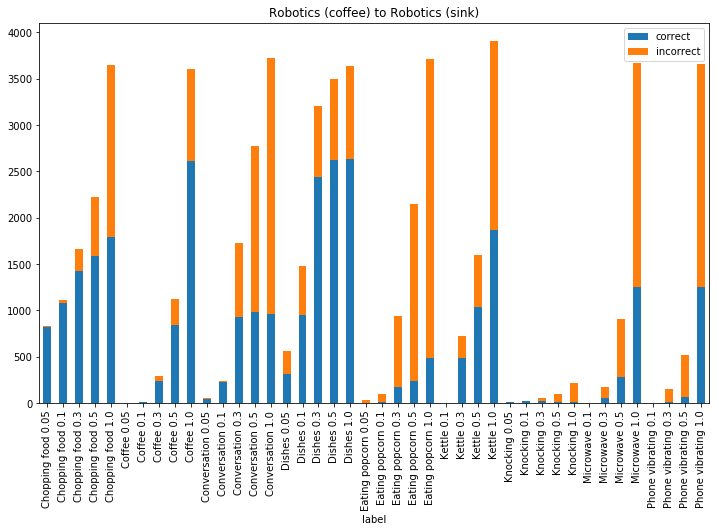

In [12]:
for i, label in enumerate(test_labels):
    subdf = results_df.loc[results_df.test == i]
    subdf = subdf[['label', 'correct', 'incorrect']]
    subdf = subdf.set_index('label')
    subdf.plot.bar(stacked=True)
    plt.title(label)

In [46]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
# cm.index = activities
# cm.columns = activities
cm

,0,1,2,3,4,5,6,7,8
0,3531,2,0,66,161,6,3,0,3
1,0,3333,0,26,24,203,2,0,9
2,1,322,0,65,298,505,1070,0,1625
3,13,158,1,486,518,216,1110,0,1212
4,34,233,0,352,621,313,898,0,1178
5,10,377,0,117,303,1240,875,0,1377
6,40,204,1,217,398,393,1009,0,1448
7,1,5,0,3,23,39,20,6,26
8,2,135,1,50,288,426,986,0,1808


In [66]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

x, y, columns = read_complete_dataset(device='128.237.248.186', dataset='synergy-final-iter2',
                             sensor_streams='MICROPHONE_fft|MICROPHONE_sst',
                             complete_df=complete_df,
                             activities=activities,
                             anomaly_percentile=50)

train_test_split = np.random.rand(len(x)) < 0.70
x_train = x[train_test_split]
y_train = y[train_test_split]
x_test = x[~train_test_split]
y_test = y[~train_test_split]

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.LinearSVC())
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

4.94871500425


0.64434687156970361

In [49]:
clf = ppl.named_steps['clf']
coefficients = clf.coef_
coefficients = pd.DataFrame(coefficients)
coefficients.columns = columns
coefficients.index = [configuration['activities'][int(i)] for i in clf.classes_]
coefficients = coefficients.T
coefficients['max'] = coefficients.max(axis=1)
coefficients = coefficients.sort_values('max', ascending=False)
coefficients = coefficients.filter(regex='^(?!max)')

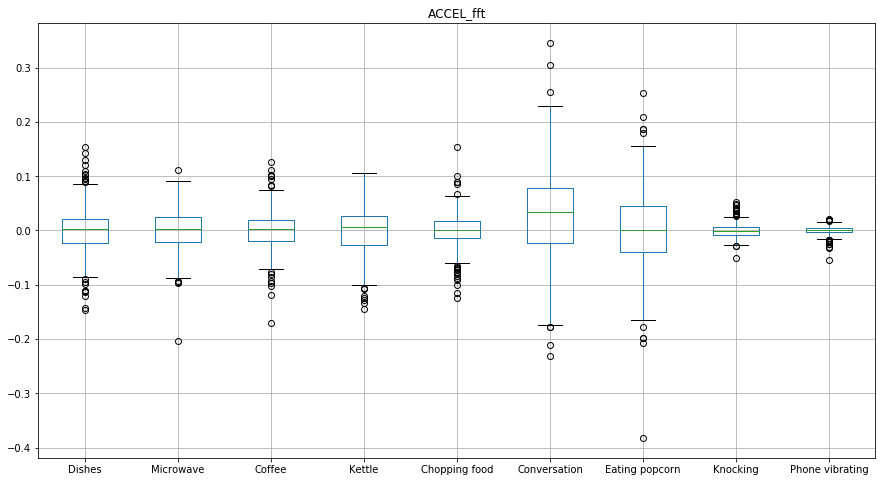

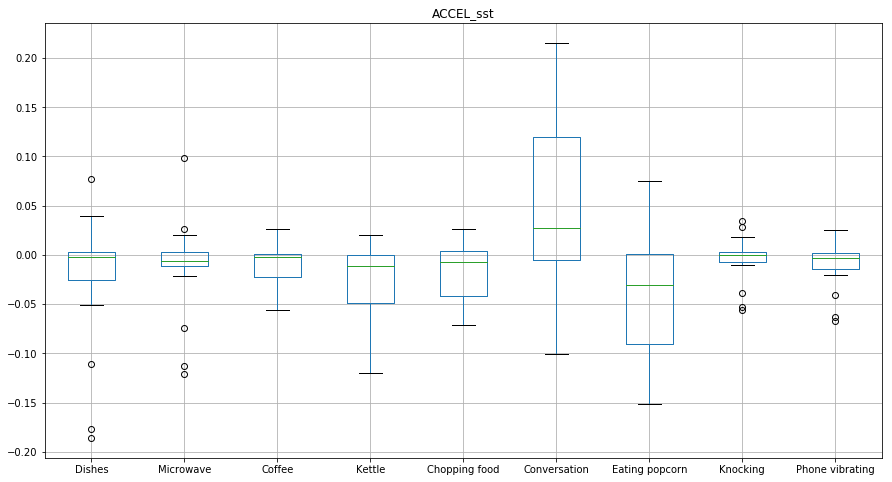

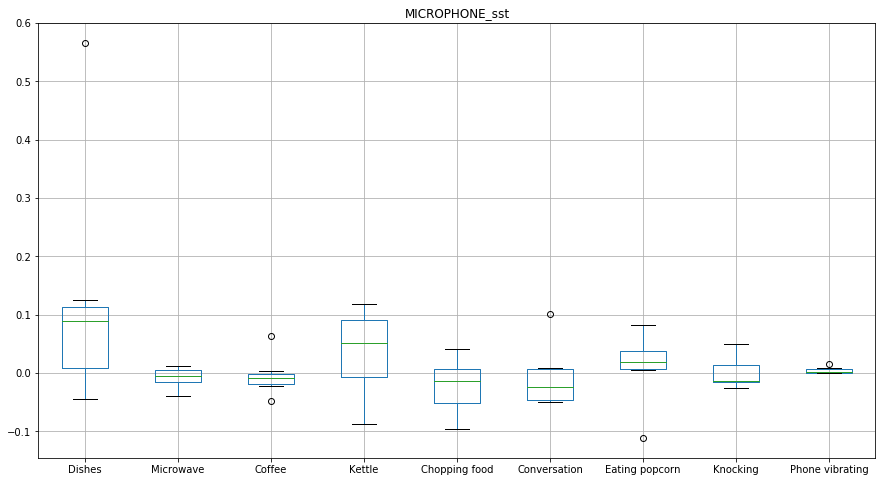

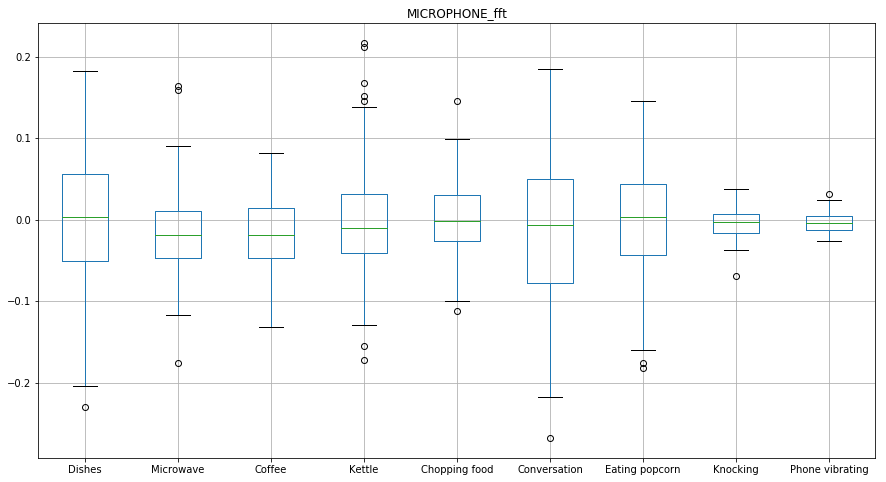

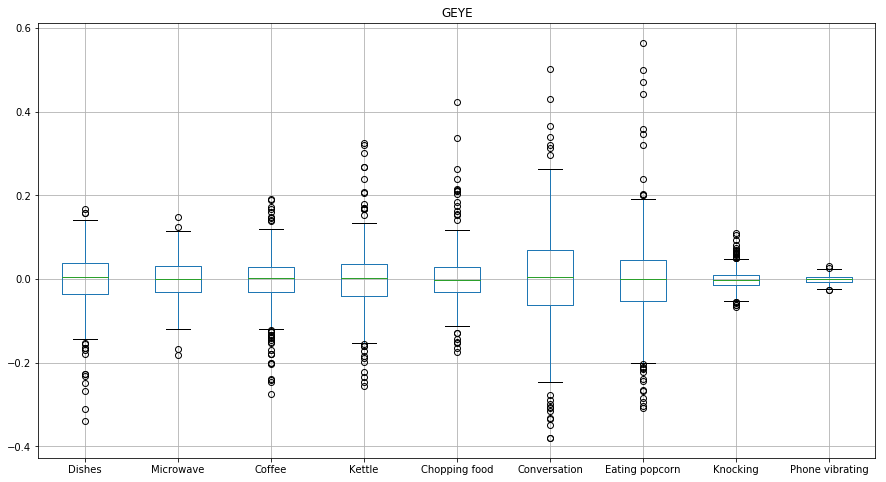

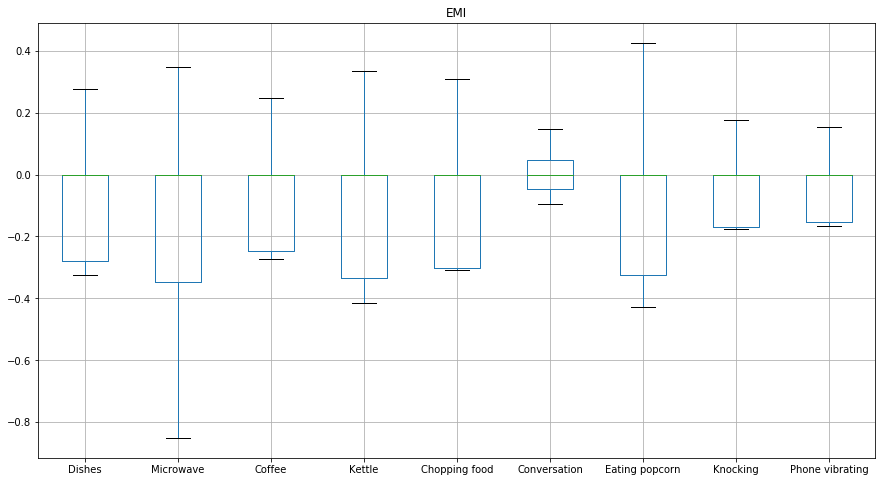

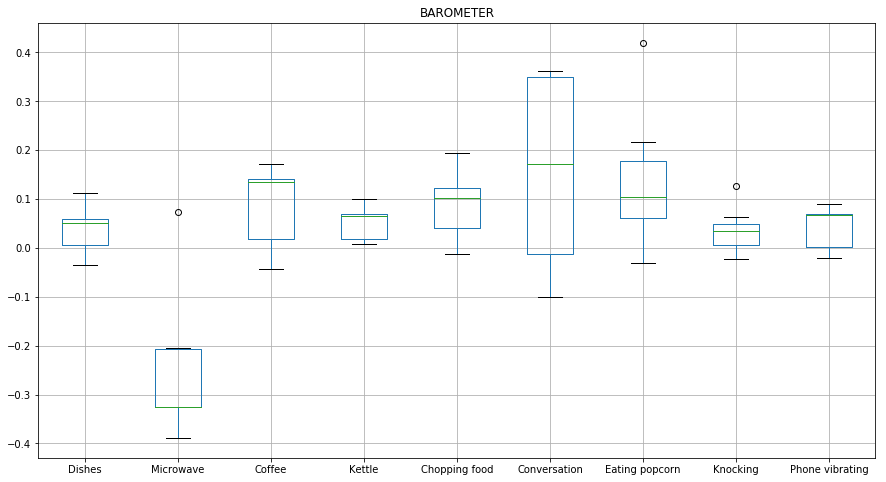

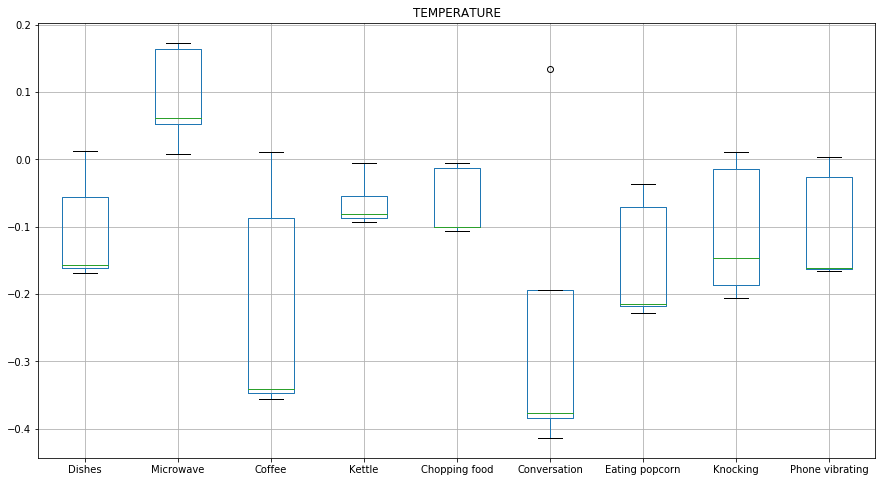

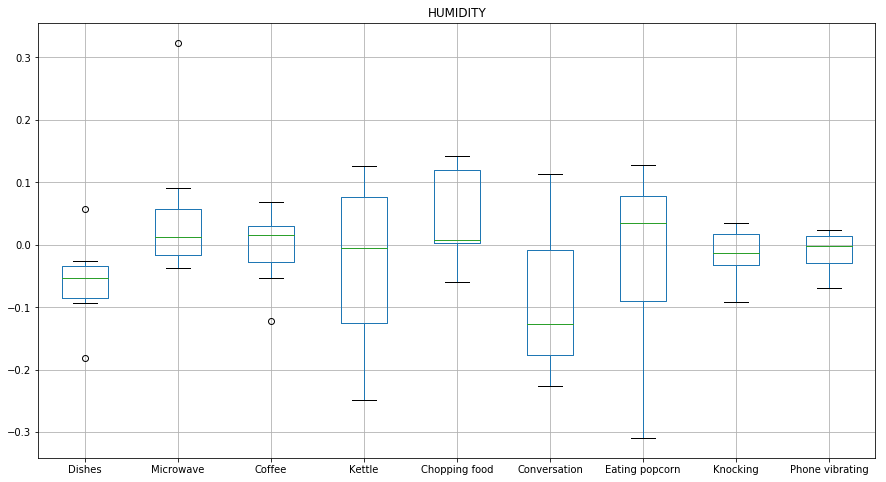

In [50]:
plt.rcParams["figure.figsize"] = (15, 8)

sensor_channels = [
    'ACCEL_fft',
    'ACCEL_sst',
    'MICROPHONE_sst',
    'MICROPHONE_fft',
    'GEYE',
    'EMI',
    'BAROMETER',
    'TEMPERATURE',
    'HUMIDITY',
]
for channel in sensor_channels:
    coefficients.loc[coefficients.index.str.startswith(channel)].boxplot()
    plt.title(channel)
    plt.show()

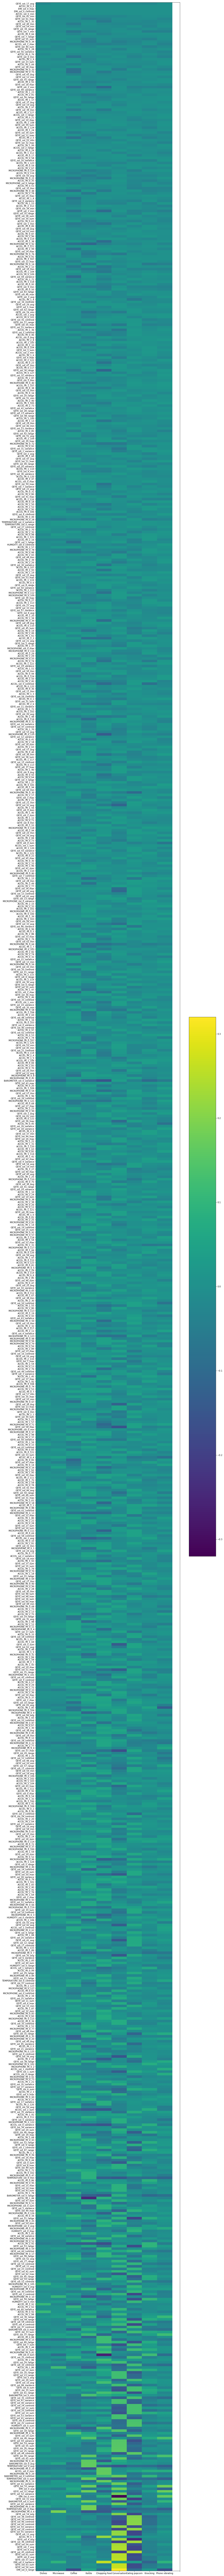

In [31]:
plt.rcParams["figure.figsize"] = (15, 220)

plt.pcolormesh(coefficients.filter(regex='^(?!max)'))
plt.yticks(np.arange(0.5, len(coefficients.index), 1), coefficients.index)
plt.xticks(np.arange(0.5, len(coefficients.columns), 1), coefficients.filter(regex='^(?!max)').columns)
plt.colorbar()